In [2]:
from lightgbm import LGBMClassifier

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import GridSearchCV
import optuna
from optuna.trial import Trial
from optuna.samplers import TPESampler
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Data Loading
X_model = pd.read_csv('X_model.csv')
Y_model = pd.read_csv('Y_model.csv')
# Define preprocessors
def preprocess(X: pd.DataFrame):
    X = X.fillna(0)
    # Create new dataframe from columns "gender", "age_code", and "region_code"
    X_new = pd.DataFrame(X, columns=['gender', 'age_code', 'region_code'])
    GIT_range = r"202205[0-9]{2}"
    cGIT = np.sum(X.filter(regex=("c" + GIT_range), axis=1).values, axis=1)
    tGIT = np.sum(X.filter(regex=("t" + GIT_range), axis=1).values, axis=1)
    sGIT = np.sum(X.filter(regex=("s" + GIT_range), axis=1).values, axis=1)

    VAT_range = r"20220[17](?:[01][0-9]|2[0-5])"
    tVAT = np.sum(X.filter(regex=("t" + VAT_range), axis=1).values, axis=1)
    sVAT = np.sum(X.filter(regex=("s" + VAT_range), axis=1).values, axis=1)

    entire_range = r"2022[0-9]{4}"
    cEntire = np.sum(X.filter(regex=("c" + entire_range), axis=1).values, axis=1)
    tEntire = np.sum(X.filter(regex=("t" + entire_range), axis=1).values, axis=1)
    sEntire = np.sum(X.filter(regex=("s" + entire_range), axis=1).values, axis=1)

    rcGIT = np.divide(cGIT, cEntire)
    rtGIT = np.divide(tGIT, tEntire)
    rsGIT = np.divide(sGIT, sEntire)

    rtVAT = np.divide(tVAT, tEntire)
    rsVAT = np.divide(sVAT, sEntire)

    X_new['cGIT'] = cGIT
    X_new['tGIT'] = tGIT
    X_new['sGIT'] = sGIT

    X_new['tVAT'] = tVAT
    X_new['sVAT'] = sVAT

    X_new['cEntire'] = cEntire
    X_new['tEntire'] = tEntire
    X_new['sEntire'] = sEntire

    X_new['rcGIT'] = rcGIT
    X_new['rtGIT'] = rtGIT
    X_new['rsGIT'] = rsGIT

    X_new['rtVAT'] = rtVAT
    X_new['rsVAT'] = rsVAT

    X_new = X_new.fillna(0)
#     print(X_new.head())

    return X_new
# Preprocess
X_model = preprocess(X_model)

        gender  age_code  region_code
0            1        13            7
1            1         5            1
2            2         6            2
3            2         1            1
4            2         5            1
...        ...       ...          ...
799995       1         6           16
799996       2        11           12
799997       1         4            7
799998       1         7            1
799999       2         7            1

[800000 rows x 3 columns]
   gender  age_code  region_code  cGIT  tGIT    sGIT  tVAT    sVAT  cEntire  \
0       1        13            7   0.0   0.0     0.0   0.0     0.0      1.0   
1       1         5            1   2.0   0.0    17.0   0.0   185.0     39.0   
2       2         6            2   6.0   3.0  2253.0   0.0  1712.0     26.0   
3       2         1            1   2.0   0.0   342.0   0.0     0.0      5.0   
4       2         5            1   2.0   0.0   273.0   0.0   104.0     10.0   

   tEntire  sEntire     rcGIT  rtGIT     r

In [76]:
#optimize by using optuna
def optimizeLGBM(trial):
    lgbm = LGBMClassifier(
                          task = "train",
                          objective = "binary", #cross-entropy
#                           boosting = "gdbt", #rf
                          n_estimators=100,
                          # to deal with overfitting, very important param
                          max_depth = trial.suggest_int('max_depth',10,20),
                          learning_rate = trial.suggest_float('learning_rate',0.02,0.1),
                          num_leaves = trial.suggest_int('num_leaves',500,1000),
                          min_data_in_leaf = trial.suggest_int('min_data_in_leaf',100,200),
                          metric = "auc",
                          #if max_bin becomes small, the accuracy goes up
                          max_bin = trial.suggest_int('max_bin',255,300),
                          tree_learner = "data",
                          lambda_l1 = trial.suggest_loguniform('lambda_l1', 1e-3, 10.0),
                          lambda_l2 = trial.suggest_loguniform('lambda_l2', 1e-3, 10.0),
                          # to deal with overfitting
                          min_child_weight = trial.suggest_int('min_child_weight', 1, 10),
                          random_state=100,
                          #for bagging imbalanced
                          bagging_fraction = trial.suggest_float('bagging_fraction', 0,1),
                          pos_bagging_fraction = trial.suggest_float('pos_bagging_fraction', 0,1),
                          neg_bagging_fraction = trial.suggest_float('neg_bagging_fraction', 0,1),
                          is_unbalance = True
#                           class_weight={0: 1, 1: 14.291397}
#                           boosting = "gdbt", #rf
#                           min_gain_to_split = ,
#                           bagging_fraction = ,
#                           early_stopping_round = ,
    )
    #cross validation K=5
    score = cross_val_score(lgbm, X_model, Y_model, cv=StratifiedKFold(n_splits=5, shuffle=True),
                            scoring="roc_auc")
    return score.mean()

optuna.logging.set_verbosity(optuna.logging.WARNING)
LGBM_study = optuna.create_study(direction='maximize')
LGBM_study.optimize(optimizeLGBM, show_progress_bar=True, n_trials=10)

# Print the best parameters
print(LGBM_study.best_params)

  0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=166, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=166
[LightGBM] [Warning] lambda_l1 is set=0.06653725557065979, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.06653725557065979
[LightGBM] [Warning] bagging_fraction is set=0.48936867021155417, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48936867021155417
[LightGBM] [Warning] lambda_l2 is set=6.196282984282408, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.196282984282408
[LightGBM] [Warning] min_data_in_leaf is set=166, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=166
[LightGBM] [Warning] lambda_l1 is set=0.06653725557065979, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.06653725557065979
[LightGBM] [Warning] bagging_fraction is set=0.48936867021155417, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48936867021155417
[LightGBM] [Warning] lambda_l2 is set=6.196282984282

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] lambda_l1 is set=0.08506599849090192, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08506599849090192
[LightGBM] [Warning] bagging_fraction is set=0.7853814746141876, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7853814746141876
[LightGBM] [Warning] lambda_l2 is set=0.08459518479028912, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.08459518479028912
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] lambda_l1 is set=0.08506599849090192, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08506599849090192
[LightGBM] [Warning] bagging_fraction is set=0.7853814746141876, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7853814746141876
[LightGBM] [Warning] lambda_l2 is set=0.084595184790

[LightGBM] [Warning] min_data_in_leaf is set=143, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=143
[LightGBM] [Warning] lambda_l1 is set=0.3474824247935692, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3474824247935692
[LightGBM] [Warning] bagging_fraction is set=0.369067502507047, subsample=1.0 will be ignored. Current value: bagging_fraction=0.369067502507047
[LightGBM] [Warning] lambda_l2 is set=1.1094955785904856, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1094955785904856
[LightGBM] [Warning] min_data_in_leaf is set=143, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=143
[LightGBM] [Warning] lambda_l1 is set=0.3474824247935692, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3474824247935692
[LightGBM] [Warning] bagging_fraction is set=0.369067502507047, subsample=1.0 will be ignored. Current value: bagging_fraction=0.369067502507047
[LightGBM] [Warning] lambda_l2 is set=1.1094955785904856, reg_

[LightGBM] [Warning] min_data_in_leaf is set=176, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=176
[LightGBM] [Warning] lambda_l1 is set=0.004980676034586452, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004980676034586452
[LightGBM] [Warning] bagging_fraction is set=0.6546045322589368, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6546045322589368
[LightGBM] [Warning] lambda_l2 is set=0.010740028641427871, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.010740028641427871
[LightGBM] [Warning] min_data_in_leaf is set=176, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=176
[LightGBM] [Warning] lambda_l1 is set=0.004980676034586452, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004980676034586452
[LightGBM] [Warning] bagging_fraction is set=0.6546045322589368, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6546045322589368
[LightGBM] [Warning] lambda_l2 is set=0.010740

In [77]:
# apply model and fit
optimized_LGBM = LGBMClassifier(task = "predict",
                          objective = "binary", # cross-entropy
#                           boosting = gdbt, #rf
                          n_estimators=100,
                          # to deal with overfitting, very important param
                          max_depth = LGBM_study.best_params['max_depth'],
                          learning_rate = LGBM_study.best_params['learning_rate'], # if it becomes 0.01(maybe?)the result proba becomes extremely small
                          num_leaves = LGBM_study.best_params['num_leaves'],
                          min_data_in_leaf = LGBM_study.best_params['min_data_in_leaf'],
                          metric = "auc",
                          #if max_bin becomes small, the accuracy goes up
                          max_bin = LGBM_study.best_params['max_bin'],
                          tree_learner = "data",
                          lambda_l1 = LGBM_study.best_params['lambda_l1'],
                          lambda_l2 = LGBM_study.best_params['lambda_l2'],
                          # to deal with overfitting
                          min_child_weight = LGBM_study.best_params['min_child_weight'], #LGBM_study.best_params['min_child_weight']
                          random_state=100,
                          bagging_fraction = LGBM_study.best_params['bagging_fraction'],
                          pos_bagging_fraction = LGBM_study.best_params['pos_bagging_fraction'],
                          neg_bagging_fraction = LGBM_study.best_params['pos_bagging_fraction'],
                          is_unbalance = True
                               )


[LightGBM] [Warning] min_data_in_leaf is set=144, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=144
[LightGBM] [Warning] lambda_l1 is set=0.2833542910181221, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2833542910181221
[LightGBM] [Warning] bagging_fraction is set=0.16227754405916328, subsample=1.0 will be ignored. Current value: bagging_fraction=0.16227754405916328
[LightGBM] [Warning] lambda_l2 is set=0.008503504616630127, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.008503504616630127
[LightGBM] [Warning] min_data_in_leaf is set=144, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=144
[LightGBM] [Warning] lambda_l1 is set=0.2833542910181221, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2833542910181221
[LightGBM] [Warning] bagging_fraction is set=0.16227754405916328, subsample=1.0 will be ignored. Current value: bagging_fraction=0.16227754405916328
[LightGBM] [Warning] lambda_l2 is set=0.0085035046

<BarContainer object of 5 artists>

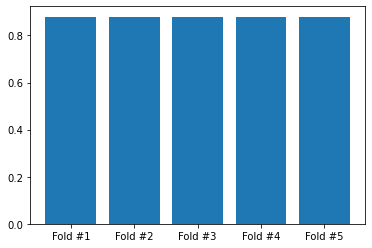

In [78]:
# evaluate
scores = cross_val_score(
    optimized_LGBM, 
    X_model, 
    Y_model, 
    cv=StratifiedKFold(n_splits=5, shuffle=True
                       ,random_state=100
                      ),
    scoring='roc_auc'
)
print("Average ROC AUC Score", np.mean(scores))
print("Standard Deviation of ROC AUC Score", np.std(scores))
# Plot 5 scores in bar plot
print(scores)
plt.bar(list(map(lambda i: f"Fold #{i}", range(1, 6))), scores)

#0.8753111530570191
#0.8756329404995423
#0.8780611462672319 when iterate 10 times

In [79]:
X_exam = pd.read_csv('X_exam.csv')
X_exam = preprocess(X_exam)

        gender  age_code  region_code
0            2         4            4
1            2        10           15
2            2         4            2
3            1         8            1
4            2         8            2
...        ...       ...          ...
199995       2         6            7
199996       1        10            6
199997       1        11            1
199998       1         4           16
199999       2         3            1

[200000 rows x 3 columns]
   gender  age_code  region_code  cGIT  tGIT   sGIT  tVAT    sVAT  cEntire  \
0       2         4            4   4.0   0.0   19.0   2.0   468.0     16.0   
1       2        10           15   0.0   0.0    0.0   0.0     0.0      7.0   
2       2         4            2   4.0   0.0  800.0   2.0  2719.0     48.0   
3       1         8            1   1.0   0.0   50.0   0.0     0.0     13.0   
4       2         8            2   0.0   0.0    0.0   1.0   488.0      1.0   

   tEntire  sEntire     rcGIT  rtGIT     rsGIT  

In [83]:
optimized_LGBM.fit(X_model,Y_model)
Y_exam = optimized_LGBM.predict_proba(X_model)[:,1]
threshold = np.array([0.5,0.7,0.75,0.76,0.77,0.78,0.79,0.8,0.9])
# the ratio of high prob with different threshold
for num in threshold: 
    filtered = Y_exam[np.where(Y_exam>num)]
    print("the number of probability more than %.2f is %d:" %(num,len(filtered)))
    print("the ratio of probability more than %.2f is : %.4f"%(num, float(len(filtered))/len(Y_exam)))
    print('--------------------------------------')
# #Y_exam.to_csv("./part1.csv",columns = "buisness prob")

[LightGBM] [Warning] min_data_in_leaf is set=144, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=144
[LightGBM] [Warning] lambda_l1 is set=0.2833542910181221, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2833542910181221
[LightGBM] [Warning] bagging_fraction is set=0.16227754405916328, subsample=1.0 will be ignored. Current value: bagging_fraction=0.16227754405916328
[LightGBM] [Warning] lambda_l2 is set=0.008503504616630127, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.008503504616630127
the number of probability more than 0.50 is 260929:
the ratio of probability more than 0.50 is : 0.3262
--------------------------------------
the number of probability more than 0.70 is 144680:
the ratio of probability more than 0.70 is : 0.1809
--------------------------------------
the number of probability more than 0.75 is 77304:
the ratio of probability more than 0.75 is : 0.0966
--------------------------------------
the number of probability mo

In [6]:
# references
# https://lightgbm.readthedocs.io/en/latest/Parameters.html
# http://devdoc.net/bigdata/LightGBM-doc-2.2.2/Parallel-Learning-Guide.html
# https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html
# https://www.kaggle.com/code/rmiperrier/tps-mar-lgbm-predict-proba-vs-predict/notebook
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
# https://www.kaggle.com/code/kageyama/predict-by-lightgbm
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_csv.html